In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import os
import openpyxl
import re
import seaborn as sns

pd.set_option("display.min_rows", 10)
pd.set_option('display.max_columns', None)

In [2]:
class GetColumns:
    def select_even_non_multiple_of_3_cols(columns, phase):
        """
        Select columns corresponding to even harmonic orders
        that are NOT multiples of 3, plus metadata columns.
        """
        base_cols = ["DateTime", f"AVG[01]_{phase}[V]"]
        meta_cols = ["Weekday", "Weekday_EN", "Time_Type"]
        harmonic_cols = [
            c for c in columns
            if c not in base_cols + meta_cols
            and c.startswith("AVG[")
            and c[4:6].isdigit()
            and int(c[4:6]) % 2 == 0
            and int(c[4:6]) % 3 != 0
        ]
        return base_cols + harmonic_cols + meta_cols

    def select_odd_non_multiple_of_3_cols(columns, phase):
        """
        Select columns corresponding to odd harmonic orders
        that are NOT multiples of 3, plus metadata columns.
        """
        base_cols = ["DateTime", f"AVG[01]_{phase}[V]"]
        meta_cols = ["Weekday", "Weekday_EN", "Time_Type"]
    
        harmonic_cols = [
            c for c in columns
            if c not in base_cols + meta_cols
            and c.startswith("AVG[")
            and c[4:6].isdigit()
            and int(c[4:6]) % 2 != 0
            and int(c[4:6]) % 3 != 0
        ]
    
        return base_cols + harmonic_cols + meta_cols

    def select_multiple_of_3_cols(columns, phase):
        """
        Select columns corresponding to harmonic orders
        that are multiples of 3, plus metadata columns.
        """
        base_cols = ["DateTime", f"AVG[01]_{phase}[V]"]
        meta_cols = ["Weekday", "Weekday_EN", "Time_Type"]
    
        harmonic_cols = [
            c for c in columns
            if c not in base_cols + meta_cols
            and c.startswith("AVG[")
            and c[4:6].isdigit()
            and int(c[4:6]) % 3 == 0
        ]
    
        return base_cols + harmonic_cols + meta_cols


In [3]:
class GetDataFrame:
    EQUIPMENT_LIST = ("CW500Viewer", "equip2")

    def __init__(self, equip_model: str, file_path: str):
        if equip_model not in self.EQUIPMENT_LIST:
            raise ValueError(f"equip_model must be one of {self.EQUIPMENT_LIST}. Got: {equip_model}")

        self.equip_model = equip_model
        self.file_path = file_path
        self.df = None  

    def load(self, phase='') -> pd.DataFrame:
        if self.equip_model == "CW500Viewer":
            self.df = self._get_and_clean_cw500_df()
            return self.df
            
        elif self.equip_model == "equip2":
            self.df = self._get_and_clean_equip2_df(phase)
            return self.df
  
        raise ValueError(f"Unsupported equip_model: {self.equip_model}")

    def _get_and_clean_cw500_df(self) -> pd.DataFrame:
        df = pd.read_csv(self.file_path, sep=';', decimal=',', skiprows=37, index_col=0)
        df = df.drop(columns=['ELAPSED TIME','Unnamed: 53'])
        df["DateTime"] = pd.to_datetime(df["DateTime"], format="%Y/%m/%d %H:%M:%S")

        num_cols = df.columns[2:]
        df[num_cols] = df[num_cols].astype(float)

        return df
        
    @staticmethod
    def rename_columns(df, phase='Va avg'):
        if phase == 'Va avg' or phase == 'ChA':
            _phase = 'V1'
        elif phase == 'Vb avg' or phase == 'ChB':
            _phase = 'V2'
        elif phase == 'Vc avg' or phase == 'ChC':
            _phase = 'V3'
        else:
            raise ValueError(f"phase not found: {phase}")
            
        new_cols = {}
        cols = []
        for col in df.columns:
            if (phase not in col) or ('HarmI' in col):
                continue
            if col.startswith('HarmV'):
                num = col[5:7]
            elif col.startswith('H') and not col.startswith(('HarmV')):
                num = col[1:3]
                   
            new_col = f'AVG[{num}]_{_phase}[V]'
            new_cols[col] = new_col
            cols.append(new_col)
        
        df = df.rename(columns=new_cols)  
        cols_with_datetime = ['DateTime'] + cols
        
        return df[cols_with_datetime]
        
    @staticmethod
    def percent_to_decimal(df):
        """
        Converts percentage columns to decimals relative to the first numeric column of the DataFrame.
        Assumes the first column is 'DateTime' and the second column is the fundamental value.
        """
        # Fundamental column (second column)
        fundamental_col = df.columns[1]
    
        # Percentage columns (all columns after the second)
        percentage_cols = df.columns[2:]
    
        # Convert percentages to decimals
        df.loc[:, percentage_cols] = df.loc[:, percentage_cols].apply(
            lambda x: x * df[fundamental_col]
        )
        return df

    def _get_and_clean_equip2_df(self, phase) -> pd.DataFrame:
        df = pd.read_excel(path)
        if "Registro" in df.columns:
            df = df.rename(columns={'Registro': 'DateTime'})
        elif "time" in df.columns:
            df = df.rename(columns={'time': 'DateTime'})

        df = self.rename_columns(df, phase)

        mask = df.map(lambda x: isinstance(x, str)).any(axis=1)
        df = df[~mask].reset_index(drop=True)
        df["DateTime"] = pd.to_datetime(df["DateTime"], format="%Y/%m/%d %H:%M:%S")
        
        num_cols = df.columns[1:]
        df[num_cols] = df[num_cols].astype(float)
        
        df = self.percent_to_decimal(df)
        return df


In [4]:
equip_model = 'CW500Viewer'

In [5]:
if equip_model == 'CW500Viewer':
    _dir = r"..\00_data\CW500Viewer\1_dados_harmonicas_tensao"
    files = [file for file in os.listdir(_dir) if file.endswith(".csv")]
elif equip_model == "equip2":
    _dir = r"..\00_data\Arquivos_CD_Rennner\CD_Renner_files_hamonics"
    files = [file for file in os.listdir(_dir) if file.endswith(".xlsx")]
    
list(zip(list(range(len(files))),files))

[(0, 'harmonicas_tensao_QGBT2_V1_INPS0014.csv'),
 (1, 'harmonicas_tensao_QGBT2_V2_INPS0014.csv'),
 (2, 'harmonicas_tensao_QGBT2_V3_INPS0014.csv'),
 (3, 'harmonicas_tensao_QGBT3_V1_INPS0013.csv'),
 (4, 'harmonicas_tensao_QGBT3_V2_INPS0013.csv'),
 (5, 'harmonicas_tensao_QGBT3_V3_INPS0013.csv'),
 (6, 'harmonicas_tensao_QGBT4_V1_INSP0011.csv'),
 (7, 'harmonicas_tensao_QGBT4_V2_INSP0011.csv'),
 (8, 'harmonicas_tensao_QGBT4_V3_INSP0011.csv')]

In [6]:
path = os.path.join(_dir, files[0])
path

'..\\00_data\\CW500Viewer\\1_dados_harmonicas_tensao\\harmonicas_tensao_QGBT2_V1_INPS0014.csv'

In [7]:
if equip_model == 'CW500Viewer':
    df = GetDataFrame(equip_model, path).load()
elif equip_model == "equip2":
    phase_list = ['Va avg', 'Vb avg', 'Vc avg', 'ChA', 'ChB', 'ChC']
    df = GetDataFrame(equip_model, path).load(phase=phase_list[0])
df

,DateTime,AVG[01]_V1[V],AVG[02]_V1[V],AVG[03]_V1[V],AVG[04]_V1[V],AVG[05]_V1[V],AVG[06]_V1[V],AVG[07]_V1[V],AVG[08]_V1[V],AVG[09]_V1[V],AVG[10]_V1[V],AVG[11]_V1[V],AVG[12]_V1[V],AVG[13]_V1[V],AVG[14]_V1[V],AVG[15]_V1[V],AVG[16]_V1[V],AVG[17]_V1[V],AVG[18]_V1[V],AVG[19]_V1[V],AVG[20]_V1[V],AVG[21]_V1[V],AVG[22]_V1[V],AVG[23]_V1[V],AVG[24]_V1[V],AVG[25]_V1[V],AVG[26]_V1[V],AVG[27]_V1[V],AVG[28]_V1[V],AVG[29]_V1[V],AVG[30]_V1[V],AVG[31]_V1[V],AVG[32]_V1[V],AVG[33]_V1[V],AVG[34]_V1[V],AVG[35]_V1[V],AVG[36]_V1[V],AVG[37]_V1[V],AVG[38]_V1[V],AVG[39]_V1[V],AVG[40]_V1[V],AVG[41]_V1[V],AVG[42]_V1[V],AVG[43]_V1[V],AVG[44]_V1[V],AVG[45]_V1[V],AVG[46]_V1[V],AVG[47]_V1[V],AVG[48]_V1[V],AVG[49]_V1[V],AVG[50]_V1[V]
No,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2023-03-03 14:38:43,226.6031,0.007603,0.500968,0.000000,3.960276,0.000000,2.905631,0.0,0.379614,0.0,0.000988,0.0,0.160102,0.0,0.175781,0.0,0.000730,0.000000,0.000000,0.0,0.006272,0.0,0.158341,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023-03-03 14:48:43,226.5847,0.022724,0.587054,0.000000,4.046276,0.000000,2.894935,0.0,0.359939,0.0,0.000129,0.0,0.139525,0.0,0.170669,0.0,0.000988,0.000000,0.000000,0.0,0.010095,0.0,0.134070,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-03-03 14:58:43,226.9951,0.027536,0.570774,0.000000,4.093014,0.000000,2.943949,0.0,0.343529,0.0,0.000430,0.0,0.169638,0.0,0.173719,0.0,0.000000,0.000000,0.000000,0.0,0.012586,0.0,0.141329,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023-03-03 15:08:43,227.6898,0.033979,0.589503,0.000129,4.232840,0.000000,3.071274,0.0,0.348427,0.0,0.001718,0.0,0.166545,0.0,0.174879,0.0,0.000000,0.000000,0.000000,0.0,0.000558,0.0,0.159371,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2023-03-03 15:18:43,228.3666,0.009537,0.566864,0.000258,4.461200,0.000000,3.124112,0.0,0.345806,0.0,0.003480,0.0,0.178144,0.0,0.176082,0.0,0.000000,0.000000,0.000000,0.0,0.001461,0.0,0.163839,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2023-03-13 16:58:43,229.1086,0.047554,0.440999,0.002019,4.584445,0.000258,3.716708,0.0,0.332489,0.0,0.062460,0.0,0.341553,0.0,0.062546,0.0,0.002191,0.000000,0.002921,0.0,0.000000,0.0,0.164999,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1456,2023-03-13 17:08:43,229.2229,0.069720,0.466946,0.000730,4.959720,0.000000,3.542602,0.0,0.327249,0.0,0.125306,0.0,0.326862,0.0,0.063362,0.0,0.001718,0.000000,0.000988,0.0,0.000000,0.0,0.140298,0.0,0.000129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1457,2023-03-13 17:18:43,229.7508,0.035139,0.434126,0.000000,5.121927,0.000043,3.731055,0.0,0.311956,0.0,0.160145,0.0,0.338718,0.0,0.032819,0.0,0.000558,0.000000,0.003651,0.0,0.000000,0.0,0.131793,0.0,0.000129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Define Parameters

In [8]:
Workday = {
    "H_DAY": dt.time(7, 0, 0),
    "H_PEAK": dt.time(18, 0, 0),
    "H_EVENING": dt.time(21, 0, 0),
    "H_NIGHT": dt.time(23, 59, 59),
}

weekdays = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday",
}

phase = df.columns[2][8:10]

# Create DF with just 1008 measurement points

In [9]:
data_VH = df.iloc[0:1008].copy()
data_VH["Weekday"] = data_VH["DateTime"].dt.weekday
data_VH["Weekday_EN"] = data_VH["Weekday"].map(weekdays)

# --------- Determine time period (using dict)
data_VH["Time_Type"] = [
    "Day: 07h-18h" if (t >= Workday["H_DAY"]) and (t < Workday["H_PEAK"]) else
    "Peak: 18h-21h" if (t >= Workday["H_PEAK"]) and (t < Workday["H_EVENING"]) else
    "Night: 21h-00h" if (t >= Workday["H_EVENING"]) and (t < Workday["H_NIGHT"]) else
    "Early_Morning: 00h-07h"
    for t in data_VH["DateTime"].dt.time
]

data_VH

,DateTime,AVG[01]_V1[V],AVG[02]_V1[V],AVG[03]_V1[V],AVG[04]_V1[V],AVG[05]_V1[V],AVG[06]_V1[V],AVG[07]_V1[V],AVG[08]_V1[V],AVG[09]_V1[V],AVG[10]_V1[V],AVG[11]_V1[V],AVG[12]_V1[V],AVG[13]_V1[V],AVG[14]_V1[V],AVG[15]_V1[V],AVG[16]_V1[V],AVG[17]_V1[V],AVG[18]_V1[V],AVG[19]_V1[V],AVG[20]_V1[V],AVG[21]_V1[V],AVG[22]_V1[V],AVG[23]_V1[V],AVG[24]_V1[V],AVG[25]_V1[V],AVG[26]_V1[V],AVG[27]_V1[V],AVG[28]_V1[V],AVG[29]_V1[V],AVG[30]_V1[V],AVG[31]_V1[V],AVG[32]_V1[V],AVG[33]_V1[V],AVG[34]_V1[V],AVG[35]_V1[V],AVG[36]_V1[V],AVG[37]_V1[V],AVG[38]_V1[V],AVG[39]_V1[V],AVG[40]_V1[V],AVG[41]_V1[V],AVG[42]_V1[V],AVG[43]_V1[V],AVG[44]_V1[V],AVG[45]_V1[V],AVG[46]_V1[V],AVG[47]_V1[V],AVG[48]_V1[V],AVG[49]_V1[V],AVG[50]_V1[V],Weekday,Weekday_EN,Time_Type
No,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2023-03-03 14:38:43,226.6031,0.007603,0.500968,0.000000,3.960276,0.0,2.905631,0.0,0.379614,0.0,0.000988,0.0,0.160102,0.0,0.175781,0.0,0.000730,0.0,0.000000,0.0,0.006272,0.0,0.158341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,Friday,Day: 07h-18h
2,2023-03-03 14:48:43,226.5847,0.022724,0.587054,0.000000,4.046276,0.0,2.894935,0.0,0.359939,0.0,0.000129,0.0,0.139525,0.0,0.170669,0.0,0.000988,0.0,0.000000,0.0,0.010095,0.0,0.134070,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,Friday,Day: 07h-18h
3,2023-03-03 14:58:43,226.9951,0.027536,0.570774,0.000000,4.093014,0.0,2.943949,0.0,0.343529,0.0,0.000430,0.0,0.169638,0.0,0.173719,0.0,0.000000,0.0,0.000000,0.0,0.012586,0.0,0.141329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,Friday,Day: 07h-18h
4,2023-03-03 15:08:43,227.6898,0.033979,0.589503,0.000129,4.232840,0.0,3.071274,0.0,0.348427,0.0,0.001718,0.0,0.166545,0.0,0.174879,0.0,0.000000,0.0,0.000000,0.0,0.000558,0.0,0.159371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,Friday,Day: 07h-18h
5,2023-03-03 15:18:43,228.3666,0.009537,0.566864,0.000258,4.461200,0.0,3.124112,0.0,0.345806,0.0,0.003480,0.0,0.178144,0.0,0.176082,0.0,0.000000,0.0,0.000000,0.0,0.001461,0.0,0.163839,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,Friday,Day: 07h-18h
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,2023-03-10 13:48:43,224.2459,0.065381,0.334809,0.000988,3.141209,0.0,2.466694,0.0,0.331330,0.0,0.025001,0.0,0.315478,0.0,0.169767,0.0,0.035268,0.0,0.001589,0.0,0.000000,0.0,0.064694,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,Friday,Day: 07h-18h
1005,2023-03-10 13:58:43,224.3620,0.017441,0.339448,0.000000,3.051944,0.0,2.472836,0.0,0.347954,0.0,0.013016,0.0,0.321836,0.0,0.172688,0.0,0.039134,0.0,0.000129,0.0,0.000129,0.0,0.127111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,Friday,Day: 07h-18h
1006,2023-03-10 14:08:43,224.6708,0.020491,0.335239,0.000000,3.235543,0.0,2.568287,0.0,0.345720,0.0,0.016453,0.0,0.309250,0.0,0.175223,0.0,0.004253,0.0,0.000258,0.0,0.000000,0.0,0.109842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,Friday,Day: 07h-18h


In [10]:
df_out = pd.DataFrame(data_VH["DateTime"].copy())
df_out

,DateTime
No,
1,2023-03-03 14:38:43
2,2023-03-03 14:48:43
3,2023-03-03 14:58:43
4,2023-03-03 15:08:43
5,2023-03-03 15:18:43
...,...
1004,2023-03-10 13:48:43
1005,2023-03-10 13:58:43
1006,2023-03-10 14:08:43


# Total Harmonic Distortion of Voltage


$$
\Large
\mathrm{DTT}\%=\frac{\sqrt{\sum_{h=2}^{h_{\max}} V_h^{2}}}{V_1}\times 100
\quad \big(h=2,3,4,5,6,\ldots,50\big)
$$


In [11]:
def add_thd_voltage_percent(df, output_col, last_harmonic, phase):
    df_out = df.copy()

    fundamental_col = f"AVG[01]_{phase}[V]"
    v1 = df_out[fundamental_col].to_numpy(dtype=float)

    all_cols = df_out.columns
    start_col = f"AVG[02]_{phase}[V]"
    end_col = f"AVG[{int(last_harmonic):02d}]_{phase}[V]"  # pad with zero if needed
    harmonic_cols = [c for c in all_cols if start_col <= c <= end_col]
    
    vh = df_out[harmonic_cols].to_numpy(dtype=float)
    df_out[output_col] = np.sqrt((vh ** 2).sum(axis=1)) / v1 * 100
    return df_out


In [12]:
df_dtt = add_thd_voltage_percent(data_VH, output_col="DTT_%", last_harmonic=data_VH.columns[-4][4:6], phase=phase)
df_out['DTT_%'] = df_dtt['DTT_%']
df_dtt.head(1)    

,DateTime,AVG[01]_V1[V],AVG[02]_V1[V],AVG[03]_V1[V],AVG[04]_V1[V],AVG[05]_V1[V],AVG[06]_V1[V],AVG[07]_V1[V],AVG[08]_V1[V],AVG[09]_V1[V],AVG[10]_V1[V],AVG[11]_V1[V],AVG[12]_V1[V],AVG[13]_V1[V],AVG[14]_V1[V],AVG[15]_V1[V],AVG[16]_V1[V],AVG[17]_V1[V],AVG[18]_V1[V],AVG[19]_V1[V],AVG[20]_V1[V],AVG[21]_V1[V],AVG[22]_V1[V],AVG[23]_V1[V],AVG[24]_V1[V],AVG[25]_V1[V],AVG[26]_V1[V],AVG[27]_V1[V],AVG[28]_V1[V],AVG[29]_V1[V],AVG[30]_V1[V],AVG[31]_V1[V],AVG[32]_V1[V],AVG[33]_V1[V],AVG[34]_V1[V],AVG[35]_V1[V],AVG[36]_V1[V],AVG[37]_V1[V],AVG[38]_V1[V],AVG[39]_V1[V],AVG[40]_V1[V],AVG[41]_V1[V],AVG[42]_V1[V],AVG[43]_V1[V],AVG[44]_V1[V],AVG[45]_V1[V],AVG[46]_V1[V],AVG[47]_V1[V],AVG[48]_V1[V],AVG[49]_V1[V],AVG[50]_V1[V],Weekday,Weekday_EN,Time_Type,DTT_%
No,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2023-03-03 14:38:43,226.6031,0.007603,0.500968,0.0,3.960276,0.0,2.905631,0.0,0.379614,0.0,0.000988,0.0,0.160102,0.0,0.175781,0.0,0.00073,0.0,0.0,0.0,0.006272,0.0,0.158341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,Friday,Day: 07h-18h,2.188923


# Total Harmonic Distortion of Voltage for even components not multiples of 3


$$
\Large
\mathrm{DTT}_{p}\%=\frac{\sqrt{\sum_{h=2}^{h_p} V_h^{2}}}{V_1}\times 100
\quad \big(h=2,4,8,10,14,\ldots,50\big)
$$


In [13]:
def add_dttp_percent(df, output_col, last_harmonic, phase):
    df_out = df.copy()
    V1 = df_out[f"AVG[01]_{phase}[V]"].to_numpy()
    
    all_cols = df_out.columns
    start_col = f"AVG[02]_{phase}[V]"
    end_col = f"AVG[{last_harmonic}]_{phase}[V]"
    harmonic_cols = [c for c in all_cols if start_col <= c <= end_col]
    
    Vh = df_out[harmonic_cols].to_numpy()
    df_out[output_col] = np.sqrt((Vh ** 2).sum(axis=1)) / V1 * 100

    return df_out


In [14]:
even_non_multiple_of_3_cols = GetColumns.select_even_non_multiple_of_3_cols(data_VH.columns, phase)
df_dttp = data_VH[even_non_multiple_of_3_cols]

df_dttp = add_dttp_percent(df_dttp, 'DTTP_%', last_harmonic=df_dttp.columns[-4][4:6], phase=phase)
df_out['DTTP_%'] = df_dttp['DTTP_%']
df_dttp.head(1)

,DateTime,AVG[01]_V1[V],AVG[02]_V1[V],AVG[04]_V1[V],AVG[08]_V1[V],AVG[10]_V1[V],AVG[14]_V1[V],AVG[16]_V1[V],AVG[20]_V1[V],AVG[22]_V1[V],AVG[26]_V1[V],AVG[28]_V1[V],AVG[32]_V1[V],AVG[34]_V1[V],AVG[38]_V1[V],AVG[40]_V1[V],AVG[44]_V1[V],AVG[46]_V1[V],AVG[50]_V1[V],Weekday,Weekday_EN,Time_Type,DTTP_%
No,,,,,,,,,,,,,,,,,,,,,,,
1,2023-03-03 14:38:43,226.6031,0.007603,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,Friday,Day: 07h-18h,0.003355


# Harmonic Distortion for odd components not multiples of 3

$$
\Large
\mathrm{DTT}_{I}\%=\frac{\sqrt{\sum_{h=5}^{h_i} V_h^{2}}}{V_1}\times 100
\quad \big(h=5,7,11,13,\ldots,49\big)
$$


In [15]:
def add_dtti_percent(df, col_out, last_harmonic, phase):
    df_out = df.copy()
    V1 = df_out[f'AVG[01]_{phase}[V]'].to_numpy(dtype=float)

    all_cols = df_out.columns
    start_col = f'AVG[05]_{phase}[V]'
    end_col = f'AVG[{int(last_harmonic):02d}]_{phase}[V]'
    harmonic_cols = [c for c in all_cols if start_col <= c <= end_col]

    Vh = df_out[harmonic_cols].to_numpy(dtype=float)
    df_out[col_out] = np.sqrt((Vh ** 2).sum(axis=1)) / V1 * 100
    return df_out


In [16]:
odd_non_multiple_of_3_cols = GetColumns.select_odd_non_multiple_of_3_cols(data_VH.columns, phase)
df_dtti = data_VH[odd_non_multiple_of_3_cols]

df_dtti = add_dtti_percent(df_dtti, 'DTTI_%', last_harmonic=df_dtti.columns[-4][4:6], phase=phase)  # soma de h=5 até h_i=50
df_out['DTTI_%'] = df_dtti['DTTI_%']
df_dtti.head(1)

,DateTime,AVG[01]_V1[V],AVG[05]_V1[V],AVG[07]_V1[V],AVG[11]_V1[V],AVG[13]_V1[V],AVG[17]_V1[V],AVG[19]_V1[V],AVG[23]_V1[V],AVG[25]_V1[V],AVG[29]_V1[V],AVG[31]_V1[V],AVG[35]_V1[V],AVG[37]_V1[V],AVG[41]_V1[V],AVG[43]_V1[V],AVG[47]_V1[V],AVG[49]_V1[V],Weekday,Weekday_EN,Time_Type,DTTI_%
No,,,,,,,,,,,,,,,,,,,,,,
1,2023-03-03 14:38:43,226.6031,3.960276,2.905631,0.000988,0.160102,0.00073,0.0,0.158341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,Friday,Day: 07h-18h,2.169886


# Harmonic Distortion for components that are multiples of 3

$$
\Large
\mathrm{DTT}_{3}\%=\frac{\sqrt{\sum_{h=3}^{h_3} V_h^{2}}}{V_1}\times 100
\quad \big(h=3,6,9,12,\ldots,48\big)
$$


In [17]:
def add_dtt3_percent(df, col_out, last_harmonic, phase):
    df_out = df.copy()
    V1 = df_out[f'AVG[01]_{phase}[V]'].to_numpy(dtype=float)

    all_cols = df_out.columns
    start_col = f'AVG[03]_{phase}[V]'
    end_col = f'AVG[{int(last_harmonic):02d}]_{phase}[V]'
    harmonic_cols = [c for c in all_cols if start_col <= c <= end_col]

    Vh = df_out[harmonic_cols].to_numpy(dtype=float)
    df_out[col_out] = np.sqrt((Vh ** 2).sum(axis=1)) / V1 * 100

    return df_out

In [18]:
multiple_of_3_cols = GetColumns.select_multiple_of_3_cols(data_VH.columns, phase)
df_dtt3 = data_VH[multiple_of_3_cols]

df_dtt3 = add_dtt3_percent(df_dtt3, 'DTT3_%', last_harmonic=df_dtt3.columns[-4][4:6], phase=phase)  
df_out['DTT3_%'] = df_dtt3['DTT3_%']
df_dtt3.head(1)

,DateTime,AVG[01]_V1[V],AVG[03]_V1[V],AVG[06]_V1[V],AVG[09]_V1[V],AVG[12]_V1[V],AVG[15]_V1[V],AVG[18]_V1[V],AVG[21]_V1[V],AVG[24]_V1[V],AVG[27]_V1[V],AVG[30]_V1[V],AVG[33]_V1[V],AVG[36]_V1[V],AVG[39]_V1[V],AVG[42]_V1[V],AVG[45]_V1[V],AVG[48]_V1[V],Weekday,Weekday_EN,Time_Type,DTT3_%
No,,,,,,,,,,,,,,,,,,,,,,
1,2023-03-03 14:38:43,226.6031,0.500968,0.0,0.379614,0.0,0.175781,0.0,0.006272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,Friday,Day: 07h-18h,0.288035


# Summary

In [19]:
df_out[['Weekday', 'Weekday_EN', 'Time_Type']] = data_VH[['Weekday', 'Weekday_EN', 'Time_Type']]
df_out

,DateTime,DTT_%,DTTP_%,DTTI_%,DTT3_%,Weekday,Weekday_EN,Time_Type
No,,,,,,,,
1,2023-03-03 14:38:43,2.188923,0.003355,2.169886,0.288035,4,Friday,Day: 07h-18h
2,2023-03-03 14:48:43,2.219634,0.010029,2.197412,0.313137,4,Friday,Day: 07h-18h
3,2023-03-03 14:58:43,2.243859,0.012130,2.223228,0.303342,4,Friday,Day: 07h-18h
4,2023-03-03 15:08:43,2.319986,0.014924,2.299079,0.310401,4,Friday,Day: 07h-18h
5,2023-03-03 15:18:43,2.406138,0.004177,2.387256,0.300818,4,Friday,Day: 07h-18h
...,...,...,...,...,...,...,...,...
1004,2023-03-10 13:48:43,1.801082,0.029159,1.786950,0.223280,4,Friday,Day: 07h-18h
1005,2023-03-10 13:58:43,1.772616,0.007773,1.757624,0.229926,4,Friday,Day: 07h-18h
1006,2023-03-10 14:08:43,1.858553,0.009120,1.844481,0.228092,4,Friday,Day: 07h-18h


In [20]:
p95_dtt = np.percentile(df_out['DTT_%'], 95)
p95_dttp = np.percentile(df_out['DTTP_%'], 95)
p95_dtti = np.percentile(df_out['DTTI_%'], 95)
p95_dtt3 = np.percentile(df_out['DTT3_%'], 95)

{'p95_DTT': p95_dtt, 'p95_DTTP': p95_dttp, 'p95_DTTI': p95_dtti, 'p95_DTT3': p95_dtt3}

{'p95_DTT': np.float64(4.645859775819062),
 'p95_DTTP': np.float64(0.05704413974574123),
 'p95_DTTI': np.float64(4.640282211981081),
 'p95_DTT3': np.float64(0.2903340605806146)}

<table style="font-size:1.3em;border-collapse:collapse;text-align:center;"> <tr> <th rowspan="2" style="border:1px solid #000;padding:6px;">Indicador</th> <th colspan="3" style="border:1px solid #000;padding:6px;">Tensão nominal</th> </tr> <tr> <th style="border:1px solid #000;padding:6px;">\(V_n \le 2{,}3\ \text{kV}\)</th> <th style="border:1px solid #000;padding:6px;">\(2{,}3\ \text{kV} < V_n < 69\ \text{kV}\)</th> <th style="border:1px solid #000;padding:6px;">\(69\ \text{kV} \le V_n < 230\ \text{kV}\)</th> </tr> <tr><td style="border:1px solid #000;padding:6px;">DTT95%</td> <td style="border:1px solid #000;padding:6px;">10,0%</td><td style="border:1px solid #000;padding:6px;">8,0%</td><td style="border:1px solid #000;padding:6px;">5,0%</td></tr> <tr><td style="border:1px solid #000;padding:6px;">DTTp95%</td> <td style="border:1px solid #000;padding:6px;">2,5%</td><td style="border:1px solid #000;padding:6px;">2,0%</td><td style="border:1px solid #000;padding:6px;">1,0%</td></tr> <tr><td style="border:1px solid #000;padding:6px;">DTTi95%</td> <td style="border:1px solid #000;padding:6px;">7,5%</td><td style="border:1px solid #000;padding:6px;">6,0%</td><td style="border:1px solid #000;padding:6px;">4,0%</td></tr> <tr><td style="border:1px solid #000;padding:6px;">DTT3 95%</td> <td style="border:1px solid #000;padding:6px;">6,5%</td><td style="border:1px solid #000;padding:6px;">5,0%</td><td style="border:1px solid #000;padding:6px;">3,0%</td></tr> </table>

# Charts

In [21]:
def plot_lollipop(
    df: pd.DataFrame,
    y_col: str,
    weekday_col: str,
    figsize=(16, 4),
    dpi: int = 300,
    y_lim=(0, 1.6),
    draw_boundaries: bool = True,
    shade_alternating: bool = True,
    constant_line_value: float = None,
    constant_line_label: str = "p95_fd_min",
):
    """
    Plots a lollipop chart and adds a secondary top X-axis
    with weekday intervals defined by another DataFrame column.

    Parameters
    ----------
    constant_line_value : float or None
        If provided, draws a horizontal red line at this value.
    constant_line_label : str or None
        Label shown in the legend for the horizontal line.
    """

    n = len(df)
    if n == 0:
        raise ValueError("Empty DataFrame.")

    # X-axis = sequential sample index
    x = np.arange(n)

    # Y series
    y = pd.to_numeric(df[y_col], errors="coerce").to_numpy()

    # Weekday column (as string)
    wd = df[weekday_col].astype(str).to_numpy()

    # --- Base plot (lollipop) ---
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.vlines(x, 0, y, linewidth=0.3)  # thin stems
    ax.scatter(x, y, s=5)              # top points

    ax.set_xlabel("Sample Number", fontsize=16)
    ax.set_ylabel(str(y_col), fontsize=16)

    if y_lim is not None:
        ax.set_ylim(*y_lim)

    ax.grid(True, axis="y", linewidth=0.3, alpha=0.5)

    # --- Constant horizontal line (optional) ---
    if constant_line_value is not None:
        ax.axhline(
            y=constant_line_value,
            color="red",
            linewidth=1,
            label=str(constant_line_label) if constant_line_label else None,
        )
        if constant_line_label:
            ax.legend(loc="upper right", fontsize=9, frameon=False)

    # --- Interval calculation (when weekday changes) ---
    if n > 1:
        change_idx = np.where(wd[1:] != wd[:-1])[0] + 1
    else:
        change_idx = np.array([], dtype=int)

    starts = np.r_[0, change_idx]
    ends = np.r_[change_idx, n]
    mids = (starts + ends - 1) / 2.0
    labels = [wd[s] for s in starts]

    # --- Top axis with weekday labels ---
    ax_top = ax.twiny()
    ax_top.set_xlim(ax.get_xlim())
    ax_top.set_xticks(mids)
    ax_top.set_xticklabels(labels, fontsize=12)
    ax_top.xaxis.set_ticks_position("top")
    ax_top.tick_params(axis="x", which="both", length=0, pad=6)
    ax_top.set_xlabel("Weekdays", fontsize=16, labelpad=8)

    # Boundary lines between weekdays (optional)
    if draw_boundaries and len(change_idx) > 0:
        for idx in change_idx:
            ax.axvline(idx, linestyle="--", linewidth=0.5, alpha=0.5)

    # Alternating block shading (optional)
    if shade_alternating:
        for i, (s, e) in enumerate(zip(starts, ends)):
            if i % 2 == 0:
                ax.axvspan(s - 0.5, e - 0.5, alpha=0.06)

    plt.tight_layout()
    return fig, ax, ax_top


In [22]:
df_out

,DateTime,DTT_%,DTTP_%,DTTI_%,DTT3_%,Weekday,Weekday_EN,Time_Type
No,,,,,,,,
1,2023-03-03 14:38:43,2.188923,0.003355,2.169886,0.288035,4,Friday,Day: 07h-18h
2,2023-03-03 14:48:43,2.219634,0.010029,2.197412,0.313137,4,Friday,Day: 07h-18h
3,2023-03-03 14:58:43,2.243859,0.012130,2.223228,0.303342,4,Friday,Day: 07h-18h
4,2023-03-03 15:08:43,2.319986,0.014924,2.299079,0.310401,4,Friday,Day: 07h-18h
5,2023-03-03 15:18:43,2.406138,0.004177,2.387256,0.300818,4,Friday,Day: 07h-18h
...,...,...,...,...,...,...,...,...
1004,2023-03-10 13:48:43,1.801082,0.029159,1.786950,0.223280,4,Friday,Day: 07h-18h
1005,2023-03-10 13:58:43,1.772616,0.007773,1.757624,0.229926,4,Friday,Day: 07h-18h
1006,2023-03-10 14:08:43,1.858553,0.009120,1.844481,0.228092,4,Friday,Day: 07h-18h


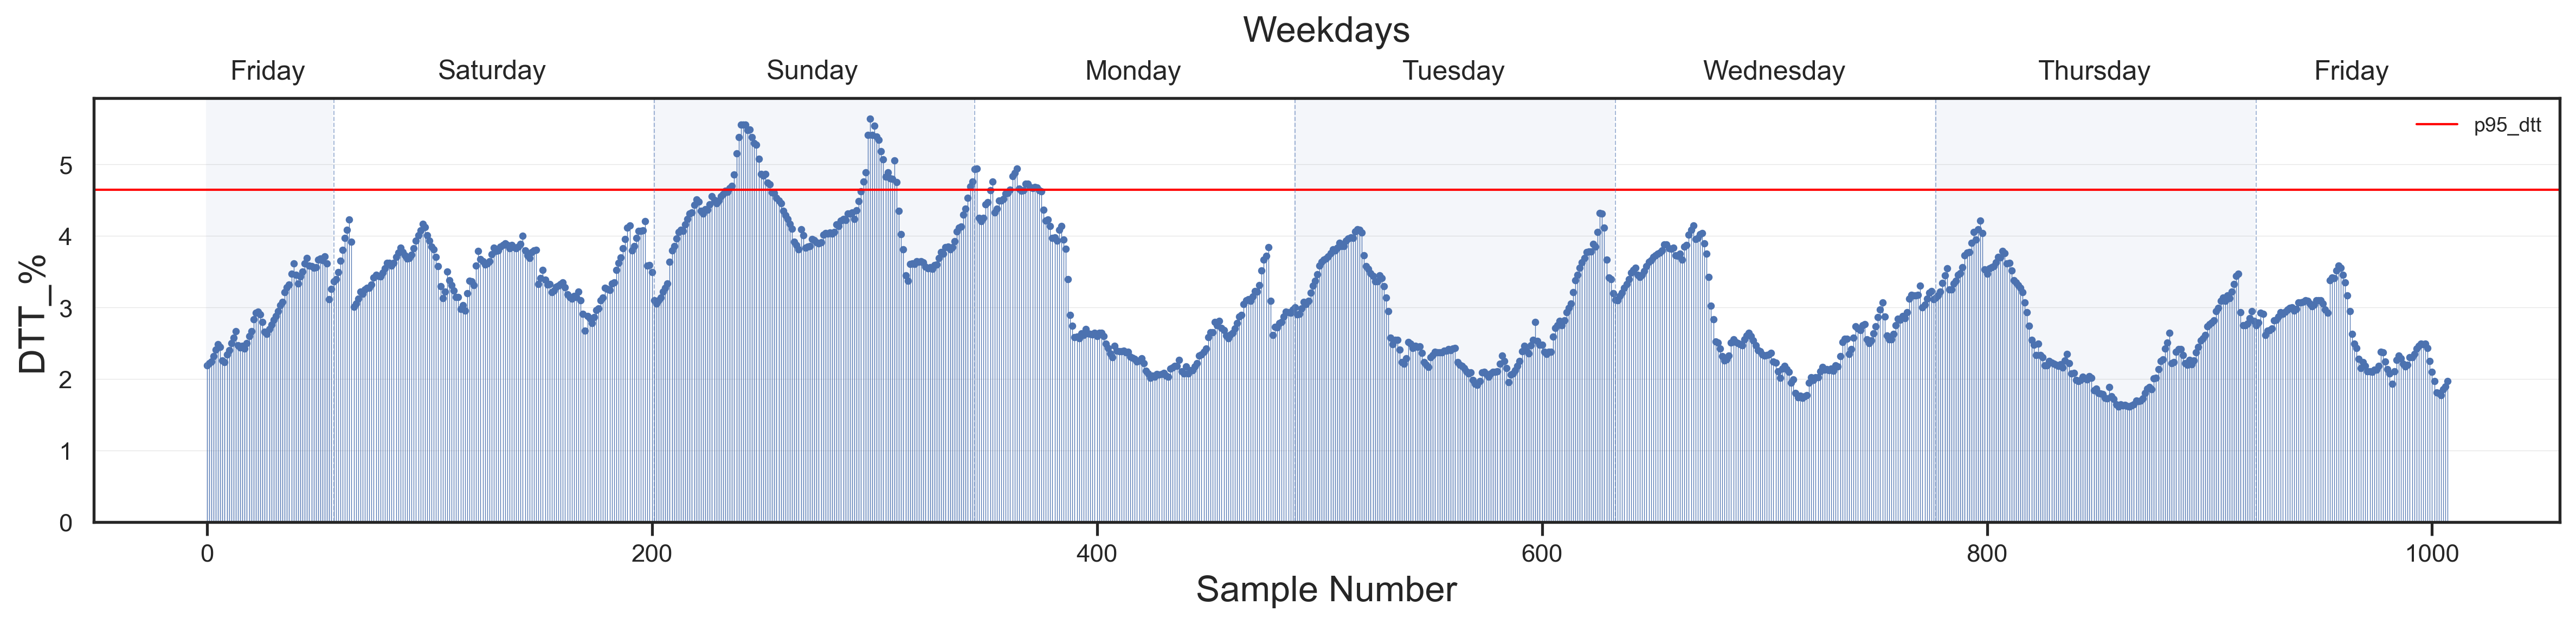

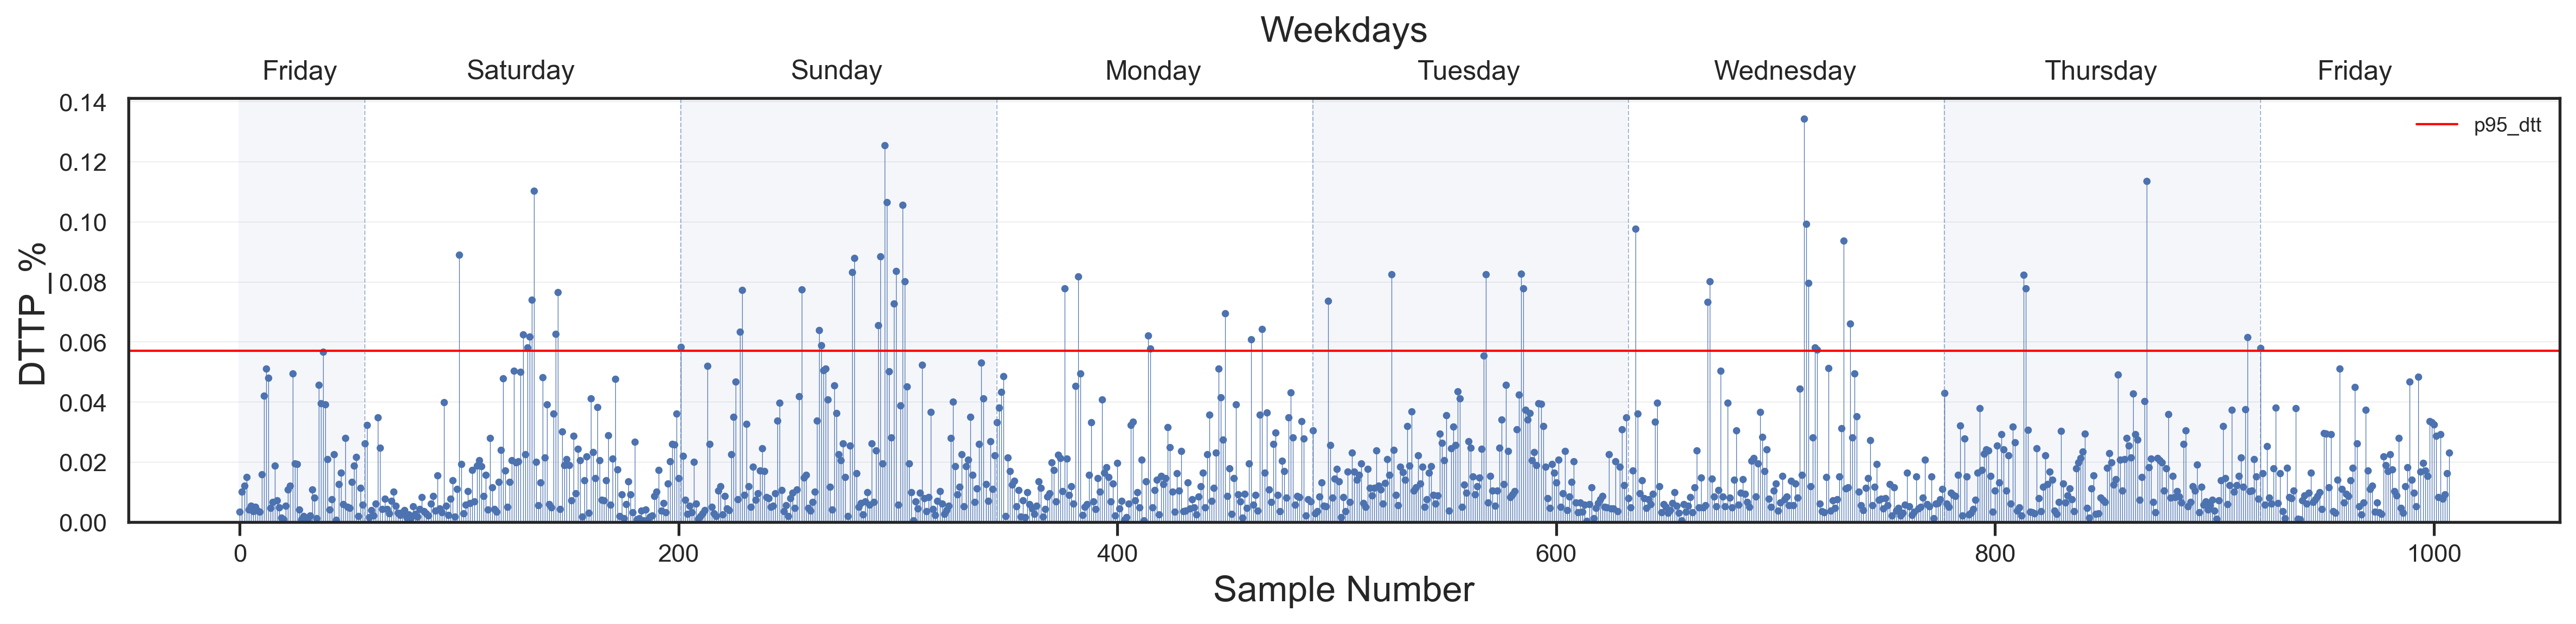

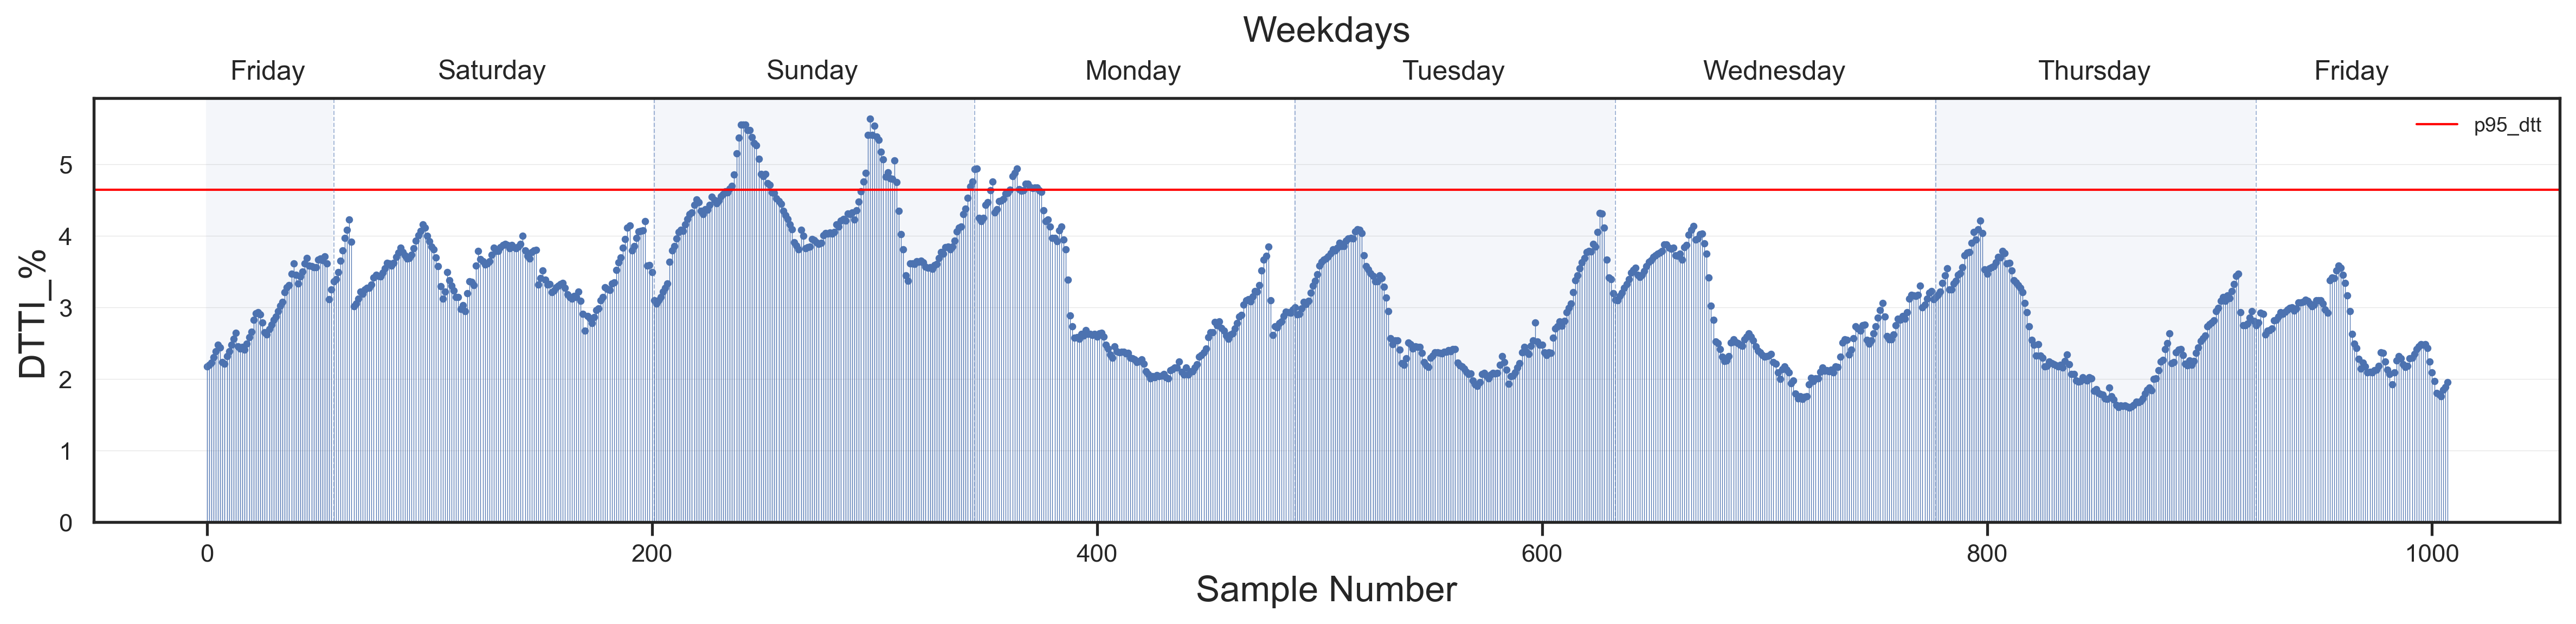

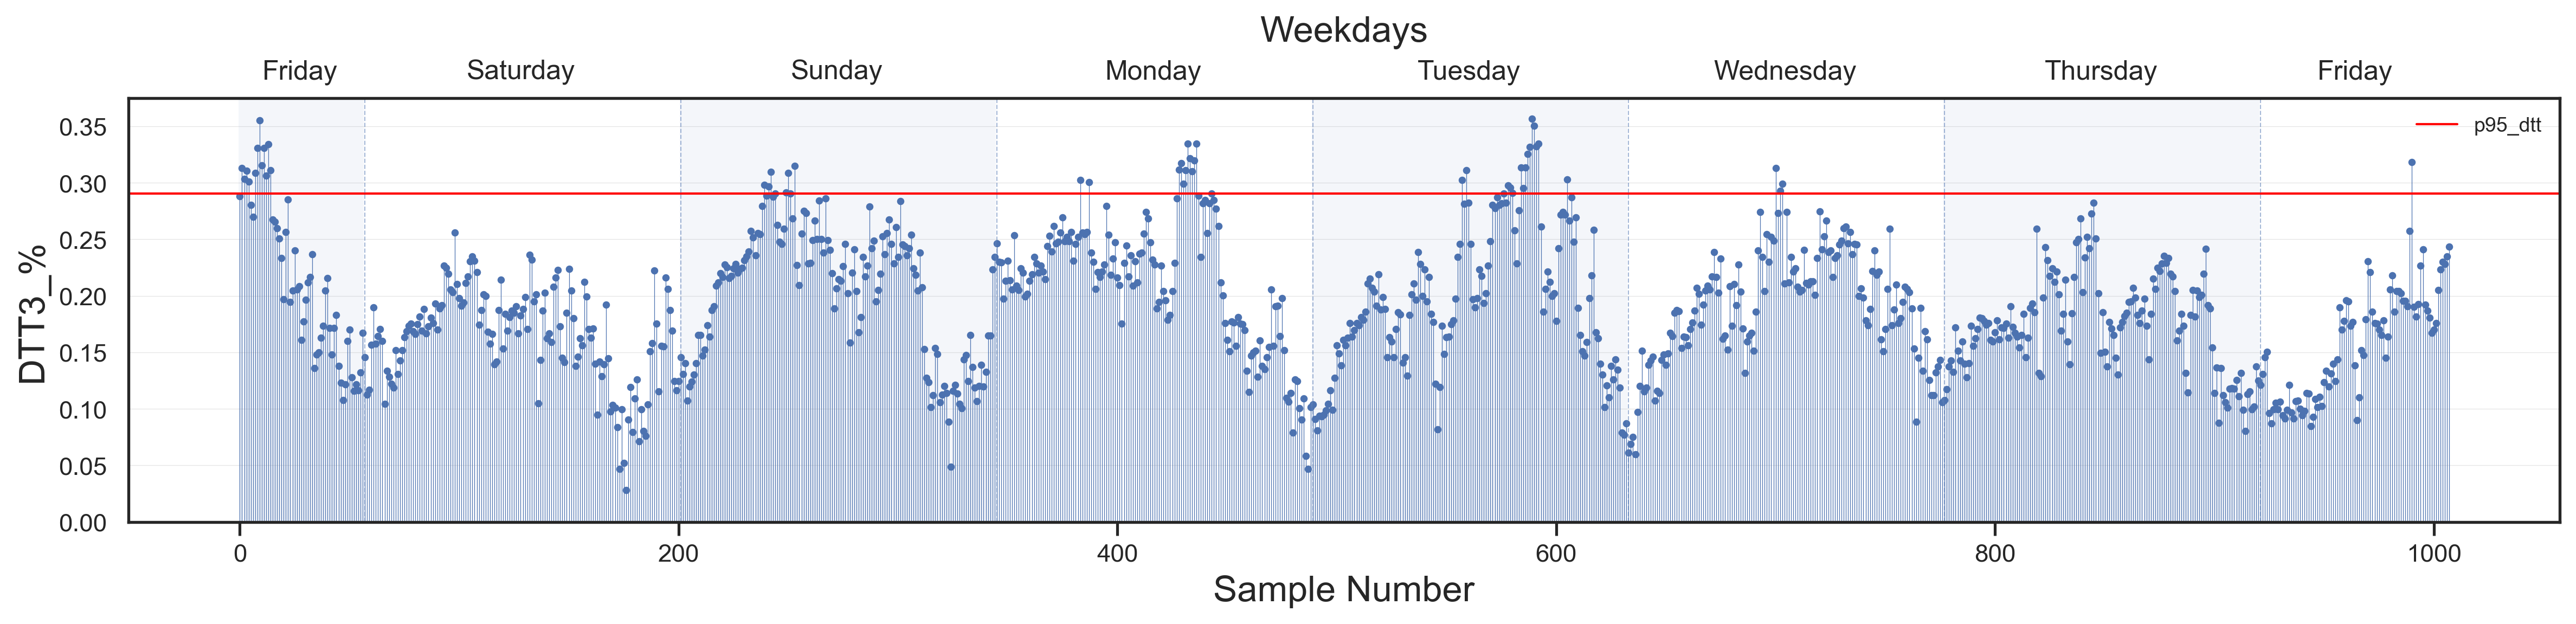

In [32]:
fig = plot_lollipop(df_out, 'DTT_%', 'Weekday_EN', constant_line_value=p95_dtt, constant_line_label="p95_dtt", y_lim = (0, df_out['DTT_%'].max() + df_out['DTT_%'].max()*0.05))
fig = plot_lollipop(df_out, 'DTTP_%', 'Weekday_EN', constant_line_value=p95_dttp, constant_line_label="p95_dtt", y_lim = (0, df_out['DTTP_%'].max()+ df_out['DTTP_%'].max()*0.05))
fig = plot_lollipop(df_out, 'DTTI_%', 'Weekday_EN', constant_line_value=p95_dtti, constant_line_label="p95_dtt", y_lim = (0, df_out['DTTI_%'].max()+ df_out['DTTI_%'].max()*0.05))
fig = plot_lollipop(df_out, 'DTT3_%', 'Weekday_EN', constant_line_value=p95_dtt3, constant_line_label="p95_dtt", y_lim = (0, df_out['DTT3_%'].max()+ df_out['DTT3_%'].max()*0.05))

# Harmonic Chart

In [24]:
def plot_harmonic_lollipop(
    df: pd.DataFrame,
    phase: str,
    unit: str = "[V]",              # "[A]" for current, "[V]" for voltage
    percentile: float = 0.95,
    exclude_fundamental: bool = True,
    figsize: tuple = (16, 5),
    dpi: int = 300,
    shade: bool = True,
    line_color: str = "C0",
    point_color: str = "C3",
    linewidth: float = 0.7,
    point_size: float = 30.0,
):

    # --- Select columns by unit ---
    cols = [c for c in df.columns if unit in c]
    if not cols:
        raise ValueError(f"No columns containing {unit} were found in the DataFrame.")

    # --- Optionally exclude the fundamental (assumed to be the first column) ---
    cols_to_plot = cols[1:] if (exclude_fundamental and len(cols) > 1) else cols
    if not cols_to_plot:
        raise ValueError("After excluding the fundamental, no columns remain to plot.")

    # --- Compute the desired percentile and drop NaNs ---
    values = df[cols_to_plot].quantile(percentile).dropna()

    # --- Extract harmonic labels (number inside the column name) ---
    def _extract_harmonic(col_name: str) -> str:
        m = re.search(r"(\d+)", col_name)
        if m:
            return m.group(1)
        return col_name.replace(unit, "").strip()

    harmonics = [_extract_harmonic(c) for c in values.index]

    # --- Auxiliary DataFrame for plotting ---
    df_percentiles = pd.DataFrame({
        "Harmonic": harmonics,
        "Value": values.values
    })
    df_percentiles["Sample"] = np.arange(len(df_percentiles))

    # --- Y-axis label according to unit ---
    if unit == "[A]":
        ylabel = "Current [A]"
    elif unit == "[V]":
        ylabel = "Voltage [V]"
    else:
        ylabel = f"Value {unit}"

    # --- Lollipop plot ---
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.vlines(
        df_percentiles["Sample"],
        0,
        df_percentiles["Value"],
        color=line_color,
        linewidth=linewidth
    )
    ax.scatter(
        df_percentiles["Sample"],
        df_percentiles["Value"],
        color=point_color,
        s=point_size,
        zorder=3
    )

    # --- Formatting ---
    ax.set_xticks(df_percentiles["Sample"])
    ax.set_xticklabels(
        df_percentiles["Harmonic"],
        rotation=45,
        ha="right",
        fontsize=12
    )
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xlabel("Harmonic", fontsize=14)
    ax.set_title(
        f"{int(percentile * 100)}th Percentile of Harmonics - Phase {phase}",
        fontsize=16
    )
    ax.grid(True, axis="y", linestyle="--", alpha=0.5)

    # --- Alternating shading ---
    if shade:
        for i in range(len(df_percentiles)):
            if i % 2 == 0:
                ax.axvspan(i - 0.5, i + 0.5, alpha=0.05, color="gray")

    plt.tight_layout()
    return fig, ax


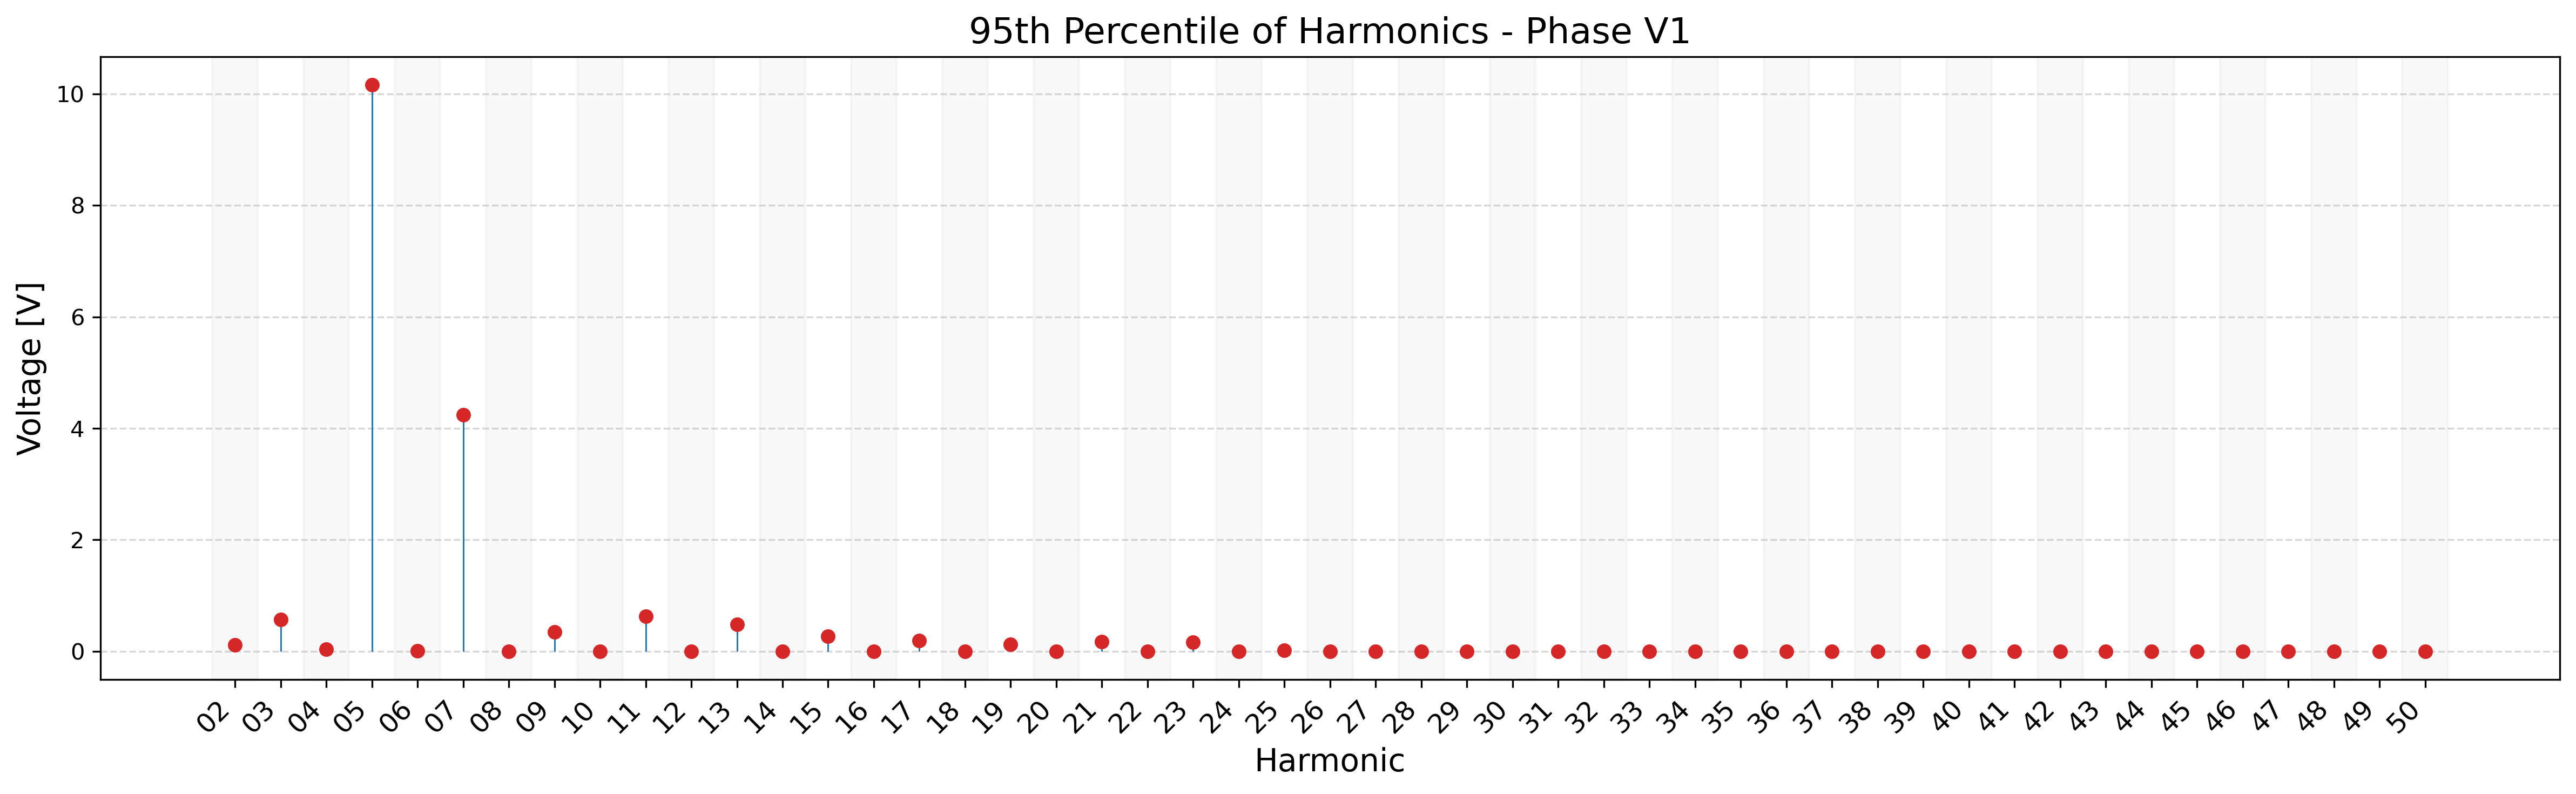

In [25]:
fig = plot_harmonic_lollipop(data_VH, phase, unit='[V]')

# Pie Chart – Harmonic Proportion


In [26]:
def harmonic_pie_chart_sns(
    df: pd.DataFrame,
    phase: str,
    unit: str = "[A]",
    percentile: float = 0.95,
    exclude_fundamental: bool = True,
    min_percent: float = 0.02,
    sort_by: str = "value",          # "value" (desc) or "harmonic" (asc)
    figsize: tuple = (5, 5),
    dpi: int = 150,
    show_value: bool = False,        # show absolute value in addition to %
    fontsize_legend: int = 11,
):
    """
    Pie chart of the proportion among harmonics with a Seaborn theme,
    legend shows harmonic and percentage, phase included in the title.
    """
    import seaborn as sns
    sns.set_theme(style="white")

    # --- Select columns by unit ---
    cols = [c for c in df.columns if unit in c]
    if not cols:
        raise ValueError(f"No columns with {unit} found in the DataFrame.")

    # --- Optionally ignore the fundamental ---
    cols_plot = cols[1:] if (exclude_fundamental and len(cols) > 1) else cols
    if not cols_plot:
        raise ValueError("After removing the fundamental, no columns remain to plot.")

    # --- Compute percentile and drop NaNs ---
    values = df[cols_plot].quantile(percentile).dropna()
    if values.empty:
        raise ValueError("No valid values for the computed percentile.")

    # --- Extract harmonic number ---
    def _extract_harmonic(col_name: str) -> int:
        m = re.search(r"(\d+)", col_name)
        return int(m.group(1)) if m else 0

    harmonic_nums = [_extract_harmonic(c) for c in values.index]

    aux = pd.DataFrame({"HarmonicNum": harmonic_nums, "Value": values.values})
    aux = aux[aux["Value"] > 0]
    if aux.empty:
        raise ValueError("All percentile values are zero; nothing to plot.")

    # --- Sorting ---
    if sort_by == "harmonic":
        aux = aux.sort_values("HarmonicNum", ascending=True)
    else:
        aux = aux.sort_values("Value", ascending=False)

    # --- Proportions and grouping small slices into "Others" ---
    total = aux["Value"].sum()
    aux["Proportion"] = aux["Value"] / total
    small = aux["Proportion"] < min_percent
    if small.any():
        other_val = aux.loc[small, "Value"].sum()
        other_prop = other_val / total
        aux = aux.loc[~small].copy()
        aux = pd.concat(
            [
                aux,
                pd.DataFrame(
                    {"HarmonicNum": [-1], "Value": [other_val], "Proportion": [other_prop]}
                ),
            ],
            ignore_index=True,
        )

    def _label(hn: int) -> str:
        return "Others" if hn == -1 else f"H{hn}"

    labels = [_label(h) for h in aux["HarmonicNum"]]
    proportions = aux["Proportion"].values

    # Prepare legend with percentage (and optional absolute value)
    legend_labels = []
    for lab, prop, val in zip(labels, proportions, aux["Value"]):
        pct = prop * 100
        text = f"{lab} ({pct:.1f}%)"
        if show_value:
            text += f" {val:.3g} {unit.strip('[]')}"
        legend_labels.append(text)

    # --- Plot ---
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    colors = sns.color_palette("tab10", len(proportions))
    wedges = ax.pie(
        proportions,
        labels=None,  # labels moved to legend
        startangle=120,
        counterclock=False,
        colors=colors,
    )[0]

    ax.axis("equal")

    # --- Legend ---
    ax.legend(
        wedges,
        legend_labels,
        title=f"Harmonics",
        loc="center left",
        bbox_to_anchor=(1.05, 0.5),
        frameon=False,
        fontsize=fontsize_legend,
    )

    # --- Title with phase ---
    unit_title = (
        "Current [A]" if unit == "[A]" else ("Voltage [V]" if unit == "[V]" else f"Value {unit}")
    )
    ax.set_title(
        f"Harmonic Proportion (P{int(percentile*100)}) - Phase {phase}\n{unit_title}",
        fontsize=14,
        pad=10,
    )

    plt.tight_layout()
    return fig, ax


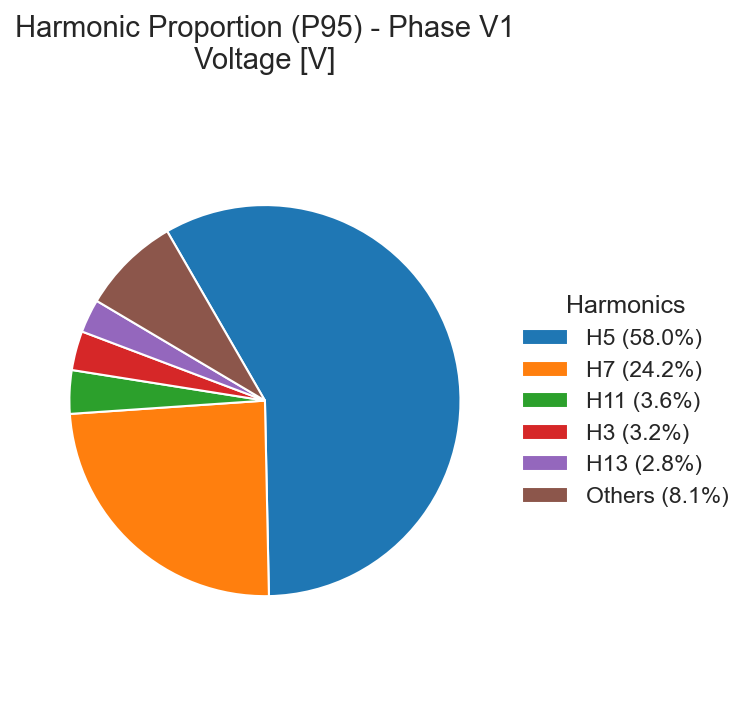

In [27]:
fig = harmonic_pie_chart_sns(data_VH, phase, unit='[V]', sort_by='valor')

# Pie Charts

In [28]:
def create_pie_chart_by_time_type_sns(
    df,
    column,
    flag_column,
    threshold_value,
    phase="",
    ax=None,
    startangle=90,
    figsize=(5, 5),
    legend_title="Category",
    title_fontsize=16,
    title_pad=10
):
    sns.set_theme(style="white")

    df = df.copy()
    df[flag_column] = np.where(df[column] > threshold_value, 1, 0)
    mask = df[flag_column] == 1

    counts = df.loc[mask, "Time_Type"].value_counts(dropna=False)
    counts = counts[counts > 0]

    if counts.sum() == 0:
        if ax is None:
            _, ax = plt.subplots(figsize=figsize)
        ax.text(0.5, 0.5, "No data", ha="center", va="center", fontsize=12)
        ax.set_title(f"{phase} | {column} > {threshold_value}", fontsize=title_fontsize, pad=title_pad)
        ax.axis("off")
        return ax

    # Ordenar em ordem decrescente
    counts = counts.sort_values(ascending=False)
    values = counts.values
    labels = counts.index.tolist()
    total = values.sum()
    percentages = values / total * 100

    legend_labels = [f"{label} ({pct:.1f}%)" for label, pct in zip(labels, percentages)]

    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    colors = sns.color_palette("tab10", len(values))

    wedges = ax.pie(
        values,
        labels=None,  # nada dentro da pizza
        startangle=startangle,
        counterclock=False,
        colors=colors,
        wedgeprops={"linewidth": 1, "edgecolor": "white"},
    )[0]

    ax.axis("equal")
    ax.set_title(f"{phase} | {column} > {threshold_value:.4f} by time of day",
                 fontsize=title_fontsize,
                 pad=title_pad)

    ax.legend(
        wedges,
        legend_labels,
        title=legend_title,
        loc="center left",
        bbox_to_anchor=(1.05, 0.5),
        frameon=False,
    )

    plt.tight_layout()
    return ax


<Axes: title={'center': 'V1 | DTT3_% > 0.2903 by time of day'}>

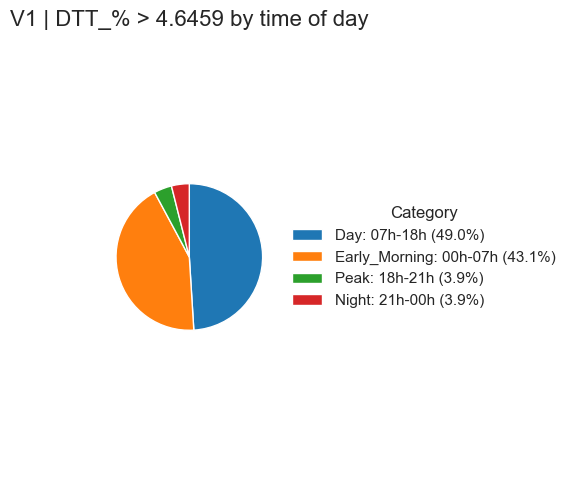

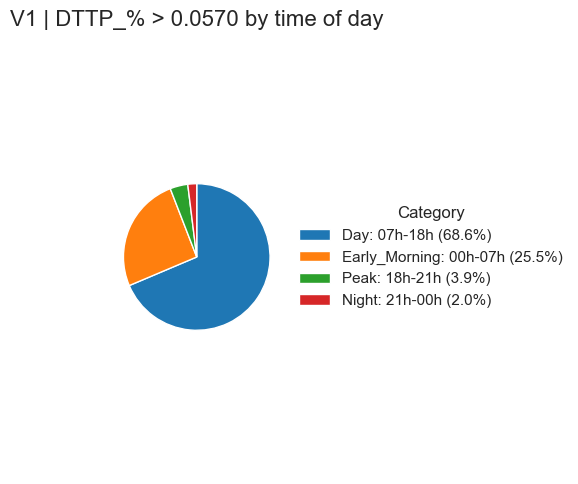

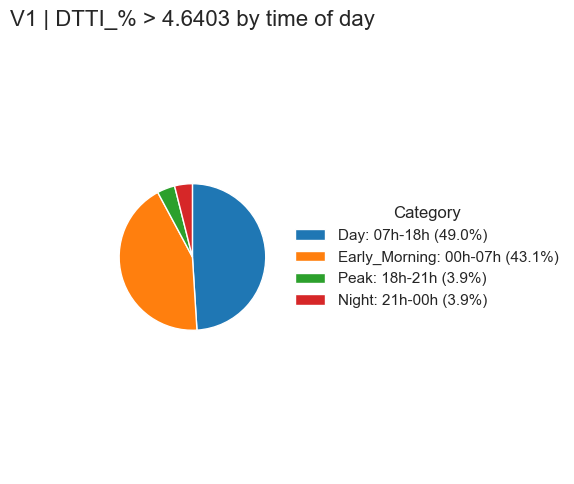

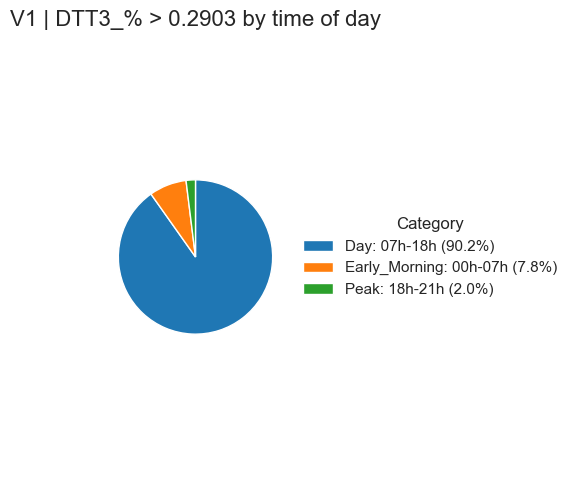

In [29]:
create_pie_chart_by_time_type_sns(df_out, 'DTT_%',  'flag_DTT_%', p95_dtt, phase)
create_pie_chart_by_time_type_sns(df_out, 'DTTP_%', 'flag_DTTP_%', p95_dttp, phase)
create_pie_chart_by_time_type_sns(df_out, 'DTTI_%', 'flag_DTTI_%', p95_dtti, phase)
create_pie_chart_by_time_type_sns(df_out, 'DTT3_%', 'flag_DTT3_%', p95_dtt3, phase)

In [30]:
def create_pie_chart_by_weekday_sns(
    df,
    column,
    flag_column,
    threshold_value,
    phase="",
    ax=None,
    startangle=90,
    figsize=(5, 5),
    legend_title="Weekday",
    title_fontsize=16,
    title_pad=10
):

    sns.set_theme(style="white")

    order = [
        "Monday", "Tuesday", "Wednesday",
        "Thursday", "Friday", "Saturday", "Sunday"
    ]

    df = df.copy()
    df[flag_column] = np.where(df[column] > threshold_value, 1, 0)
    mask = df[flag_column] == 1

    s = df.loc[mask, "Weekday_EN"].astype(
        pd.CategoricalDtype(categories=order, ordered=True)
    )
    counts = s.value_counts(sort=False)
    counts = counts[counts > 0]

    if counts.sum() == 0:
        if ax is None:
            _, ax = plt.subplots(figsize=figsize)
        ax.text(0.5, 0.5, "No data", ha="center", va="center", fontsize=12)
        ax.set_title(f"{phase} | {column} > {threshold_value}", fontsize=title_fontsize, pad=title_pad)
        ax.axis("off")
        return ax

    # Ordenar em ordem decrescente
    counts = counts.sort_values(ascending=False)
    values = counts.values
    labels = counts.index.tolist()
    total = values.sum()
    percentages = values / total * 100

    legend_labels = [
        f"{label} ({pct:.1f}%)"
        for label, pct in zip(labels, percentages)
    ]

    if ax is None:
        _, ax = plt.subplots(figsize=figsize)

    colors = sns.color_palette("tab10", len(values))

    wedges = ax.pie(
        values,
        labels=None,
        startangle=startangle,
        counterclock=False,
        colors=colors,
        wedgeprops={"linewidth": 1, "edgecolor": "white"},
    )[0]

    ax.axis("equal")
    ax.set_title(f"{phase} | {column} > {threshold_value:.4f} by weekday",
                 fontsize=title_fontsize,
                 pad=title_pad)

    ax.legend(
        wedges,
        legend_labels,
        title=legend_title,
        loc="center left",
        bbox_to_anchor=(1.05, 0.5),
        frameon=False,
    )

    plt.tight_layout()
    return ax


<Axes: title={'center': 'V1 | DTT3_% > 0.2903 by weekday'}>

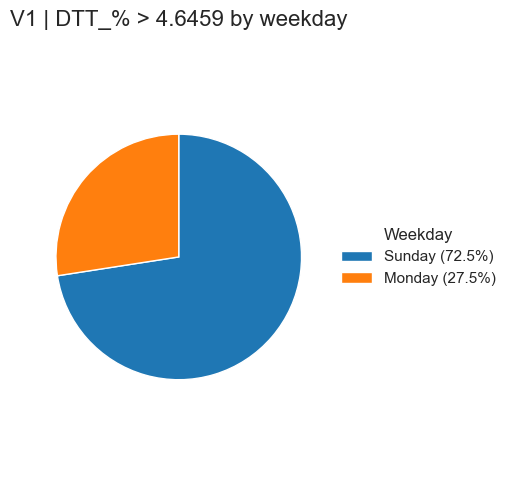

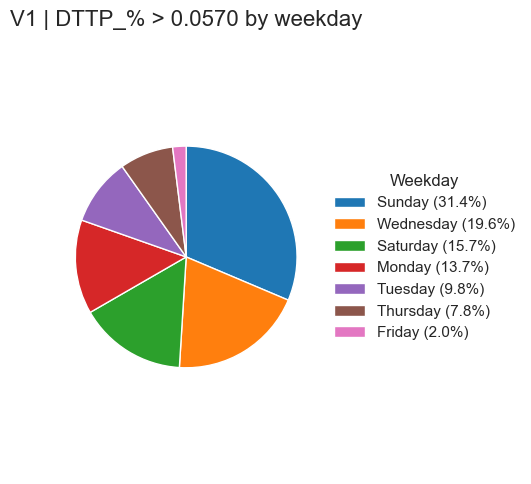

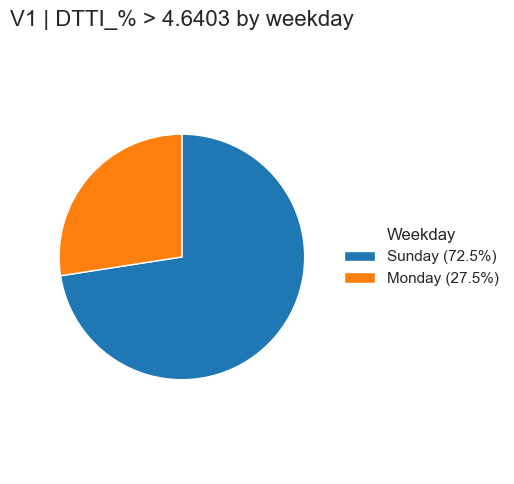

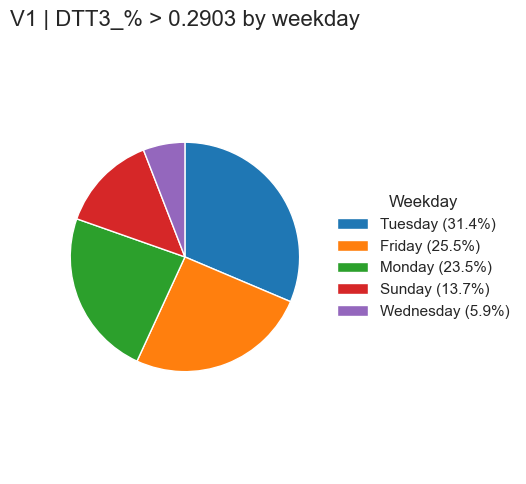

In [31]:
create_pie_chart_by_weekday_sns(df_out, 'DTT_%',  'flag_DTT_%',  p95_dtt,  phase)
create_pie_chart_by_weekday_sns(df_out, 'DTTP_%', 'flag_DTTP_%', p95_dttp, phase)
create_pie_chart_by_weekday_sns(df_out, 'DTTI_%', 'flag_DTTI_%', p95_dtti, phase)
create_pie_chart_by_weekday_sns(df_out, 'DTT3_%', 'flag_DTT3_%', p95_dtt3, phase)